## CIS 519 Group Project - CoAt Net Implementation

### Library Imports

In [1]:
!pip install timm # install PyTorch Image Models

In [2]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.parallel
from torch.utils import data
import torch.utils.data.distributed
from torchvision import datasets, transforms, models 
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim 
import timm
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split

### Helper Functions

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

### Parameter Initialization

In [4]:
class config_params:
    epochs = 3                             # No. of epochs for training the model
    lr = 0.001                             # Learning rate
    batch_size = 16                        # Batch Size for Dataset
    img_size = 224                         # Resize all the images to be 224 by 224   
    in_channels = 3                        # No of channels in input image
    num_classes = 6                        # No. of classes
    model_name = 'coat_tiny'               # Model Used

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


### Data Loading

In [5]:
#read the data from the folder
data_dir = './dataset'
classes = os.listdir(data_dir)

In [6]:
#Data Transforms to apply on the Images

train_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = transforms.Compose([
                             
                             transforms.Resize(size=(config_params.img_size,config_params.img_size)), # Resizing the image to be 224 by 224
                             transforms.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [7]:
dataset = ImageFolder(data_dir, transform= transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 58954


In [8]:
img, label = dataset[7]
print(img.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AbdomenCT (0)


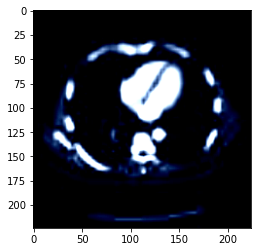

In [9]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
show_image(*dataset[1])

In [10]:
#classes in the dataset
classes

['ChestCT', 'HeadCT', 'CXR', 'BreastMRI', 'Hand', 'AbdomenCT']

In [11]:
#class to split the data and apply transformations

Labels = {'AbdomenCT':0, 'BreastMRI':1,'CXR':2,'ChestCT':3,'Hand':4,'HeadCT':5}

class MedicalMNIST(data.Dataset):
    
 
    def __init__(self, root, transforms=None, train=True, test=False, val = False):
        """
        Main objective: to obtain the addresses of all pictures and divide the data according to training, verification and test
        """
        self.test = test
        self.val = val
        self.transforms = transforms
 
        if self.test:
            imgs = [os.path.join(root, img) for img in os.listdir(root)]
            self.imgs = imgs
        else:
            imgs_labels = [os.path.join(root, img) for img in os.listdir(root)]
            imgs = []
            for imglable in imgs_labels:
                for imgname in os.listdir(imglable):
                    imgpath = os.path.join(imglable, imgname)
                    imgs.append(imgpath)
                    
            torch.manual_seed(20)
            val_size = int(round(len(dataset) * 0.2, 0))
            test_size = int(round(len(dataset) * 0.1, 0))
            train_size = len(dataset) - val_size - test_size
            train_ds, val_ds, test_ds = random_split(imgs, [train_size, val_size, test_size])
            
            #trainval_files, te_files = train_test_split(imgs, test_size=0.3, random_state=42)
            if train == True:
                self.imgs = train_ds
            elif val == True:
                self.imgs = val_ds
            else:
                self.imgs = test_ds
 
    def __getitem__(self, index):
        """
        Returns the data of one picture at a time
        """
        img_path = self.imgs[index]
        img_path=img_path.replace("\\",'/')
        if self.test:
            label = -1
        else:
            
            labelname = img_path.split('/')[-2]
            
            label = Labels[labelname]
           
        data = Image.open(img_path).convert('RGB')
        data = self.transforms(data)
        return data, label
 
    def __len__(self):
        return len(self.imgs)

In [12]:
# split the data 
batch_size = config_params.batch_size
dataset_train = MedicalMNIST(data_dir, transforms=train_transform, train=True)
dataset_val = MedicalMNIST(data_dir, transforms=transform, train=False,val=True)
dataset_test = MedicalMNIST(data_dir,transforms=test_transform, train=False)

# Import data the into DataLoader
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size= batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size= batch_size, shuffle=False)

In [13]:
print("No. of batches in trainloader:{}".format(len(train_loader))) 
print("No. of Total examples:{}".format(len(train_loader.dataset)))

print("No. of batches in validationloader:{}".format(len(val_loader))) 
print("No. of Total examples:{}".format(len(val_loader.dataset)))

print("No. of batches in testloader:{}".format(len(test_loader)))
print("No. of Total examples:{}".format(len(test_loader.dataset)))

No. of batches in trainloader:2580
No. of Total examples:41268
No. of batches in validationloader:737
No. of Total examples:11791
No. of batches in testloader:369
No. of Total examples:5895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


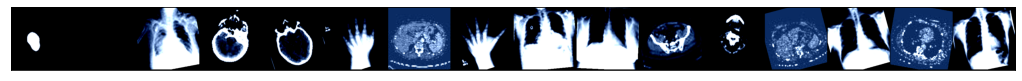

In [14]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

### Model Definiton

In [15]:
#Instantiate the model

model = timm.create_model(config_params.model_name,pretrained=True) #load pretrained model

num_ftrs = model.head.in_features

#define the model architecture
model.classifier = nn.Sequential(
    nn.Linear(in_features= num_ftrs, out_features=128), 
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=128, out_features= config_params.num_classes), 
)

print(model)



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-coat-weights/coat_tiny-473c2a20.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/coat_tiny-473c2a20.pth


CoaT(
  (patch_embed1): PatchEmbed(
    (proj): Conv2d(3, 152, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((152,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed2): PatchEmbed(
    (proj): Conv2d(152, 152, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((152,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed3): PatchEmbed(
    (proj): Conv2d(152, 152, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((152,), eps=1e-05, elementwise_affine=True)
  )
  (patch_embed4): PatchEmbed(
    (proj): Conv2d(152, 152, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((152,), eps=1e-05, elementwise_affine=True)
  )
  (cpe1): ConvPosEnc(
    (proj): Conv2d(152, 152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=152)
  )
  (cpe2): ConvPosEnc(
    (proj): Conv2d(152, 152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=152)
  )
  (cpe3): ConvPosEnc(
    (proj): Conv2d(152, 152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gr

### Training and Testing

In [17]:
#Model Trainining and Testing
class Trainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    #train loop
    def train_batch_loop(self,model,train_loader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(train_loader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(outputs,labels)
        
        #return average loss and accuracy    
        return train_loss / len(train_loader), train_acc / len(train_loader) 

    #validation loop
    def valid_batch_loop(self,model,val_loader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        for images,labels in tqdm(val_loader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images)
            loss = self.criterion(outputs,labels)
             
            valid_loss += loss.item()
            valid_acc += accuracy(outputs,labels)
            
        #return average loss and accuracy
        return valid_loss / len(val_loader), valid_acc / len(val_loader)
    
    #Testing loop
    def test_batch_loop(self,model,test_loader):
        y_pred = []
        y_true = []
        test_loss = 0.0
        test_acc = 0.0

        # iterate over test data
        for inputs, labels in test_loader:
                inputs = inputs.to(device) 
                labels = labels.to(device)
            
                output = model(inputs) # Feed Network
                
                loss = self.criterion(output,labels)
                
                test_loss += loss.item()
                test_acc += accuracy(output,labels)
            
                
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth
        
        #return labels, predictions, average loss and accuracy
        return y_true, y_pred, test_loss / len(test_loader), test_acc / len(test_loader)
        
    #fit function
    def fit(self,model,train_loader,valid_loader,epochs):
        train_loss, validation_loss = [], []
        train_acc, validation_acc = [], []
      
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,train_loader) ###
            train_loss.append(avg_train_loss)  # append the loss for this epoch
            train_acc.append(avg_train_acc)
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,valid_loader) ###
            
            validation_loss.append(avg_valid_loss)
            validation_acc.append(avg_valid_acc)
            
            
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))
        
        return train_loss, train_acc, validation_loss, validation_acc 

In [18]:
in_channels = config_params.in_channels
num_classes = config_params.num_classes
lr = config_params.lr
epochs = config_params.epochs


print(device)
model.to(device) # move the model to GPU 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr)

trainer = Trainer(criterion,optimizer) 
train_loss, train_acc, validation_loss, validation_acc = trainer.fit(model,train_loader,val_loader,epochs=3)


cuda


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 1 Train Loss : 0.060183 Train Acc : 0.985247
Epoch : 1 Valid Loss : 0.007798 Valid Acc : 0.997626


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.014437 Train Acc : 0.996148
Epoch : 2 Valid Loss : 0.001504 Valid Acc : 0.999406


  0%|          | 0/2580 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.015360 Train Acc : 0.996342
Epoch : 3 Valid Loss : 0.002307 Valid Acc : 0.999322


In [19]:
#Testing the Model on test samples

model.eval()
true, pred , avg_test_loss, avg_test_acc = trainer.test_batch_loop(model,test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

Test Loss : 0.002555612509659754
Test Acc : 0.9993224740028381


### Result Visualisations

Confusion Matrix for CoAt Net
[[ 955    0    0    0    0    0]
 [   0  919    0    0    0    0]
 [   0    0  983    0    0    0]
 [   0    0    0 1017    0    0]
 [   0    0    3    0 1029    0]
 [   0    1    0    0    0  988]]


<AxesSubplot:>

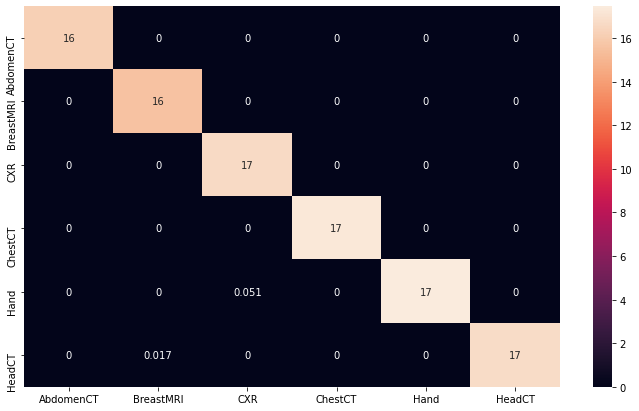

In [21]:
# labels for classes
classes = ['AbdomenCT', 'BreastMRI','CXR','ChestCT','Hand','HeadCT']

# Build confusion matrix

print("Confusion Matrix for CoAt Net")

cf_matrix = confusion_matrix(true, pred)
print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

#class-wise predictions 
sns.heatmap(df_cm, annot=True)

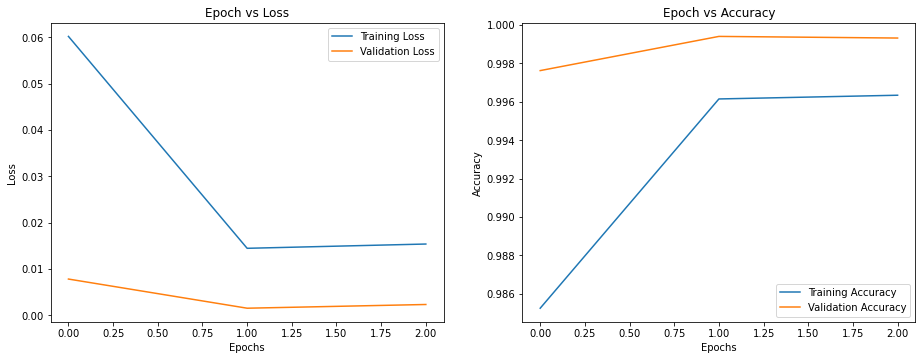

In [25]:
#Plot of accuracy and loss 
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)